/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s] 


Epoch [1/50], Loss: 0.8887, Accuracy: 54.10%
Epoch [2/50], Loss: 0.5354, Accuracy: 69.67%
Epoch [3/50], Loss: 0.3638, Accuracy: 77.87%
Epoch [4/50], Loss: 0.2428, Accuracy: 94.26%
Epoch [5/50], Loss: 0.1542, Accuracy: 97.54%
Epoch [6/50], Loss: 0.1207, Accuracy: 98.36%
Epoch [7/50], Loss: 0.1014, Accuracy: 99.18%
Epoch [8/50], Loss: 0.0660, Accuracy: 100.00%
Epoch [9/50], Loss: 0.0702, Accuracy: 100.00%
Epoch [10/50], Loss: 0.0539, Accuracy: 100.00%
Epoch [11/50], Loss: 0.0411, Accuracy: 100.00%
Epoch [12/50], Loss: 0.0436, Accuracy: 100.00%
Epoch [13/50], Loss: 0.0367, Accuracy: 100.00%
Epoch [14/50], Loss: 0.0513, Accuracy: 99.18%
Epoch [15/50], Loss: 0.0261, Accuracy: 100.00%
Epoch [16/50], Loss: 0.0341, Accuracy: 100.00%
Epoch [17/50], Loss: 0.0304, Accuracy: 100.00%
Epoch [18/50], Loss: 0.0345, Accuracy: 100.00%
Epoch [19/50], Loss: 0.0236, Accuracy: 100.00%
Epoch [20/50], Loss: 0.0398, Accuracy: 100.00%
Epoch [21/50], Loss: 0.0197, Accuracy: 100.00%
Epoch [22/50], Loss: 0.0165, A

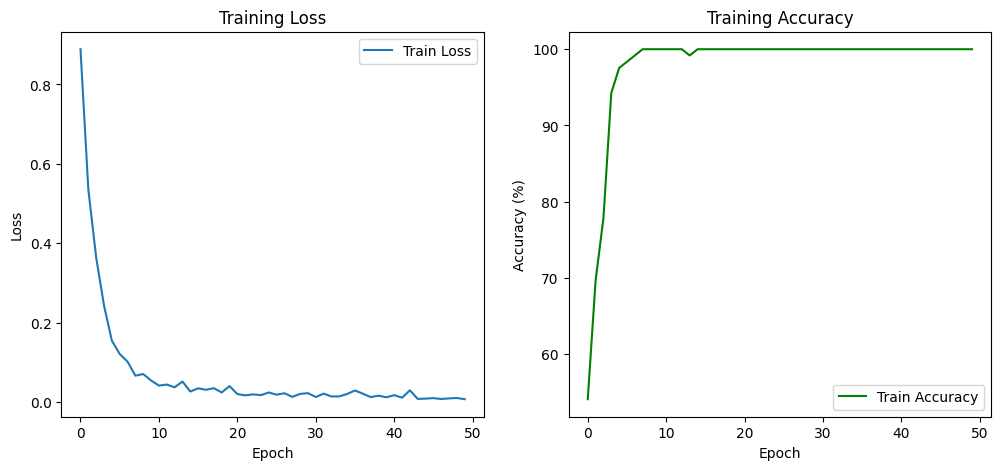

Test Accuracy: 89.02%


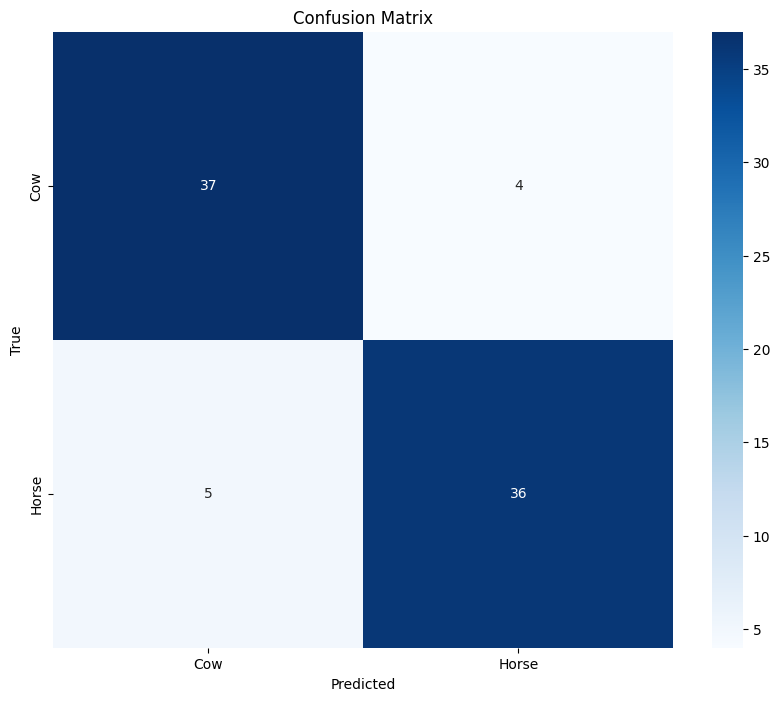

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# 2. Load datasets (change root as needed)
train_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Use Pretrained ResNet50 model from torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for your number of classes (2 classes in your case)
model.fc = nn.Linear(model.fc.in_features, 2)

# Move model to device
model = model.to(device)

# Optionally, freeze the layers if you want to fine-tune only the final layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer (this is usually the layer we fine-tune)
for param in model.fc.parameters():
    param.requires_grad = True

# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.002)

# 5. Training loop
num_epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# 6. Plot train accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()
plt.show()

# 7. Evaluation on test set + confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
correct = np.sum(np.array(y_true) == np.array(y_pred))
test_acc = 100 * correct / len(y_true)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



========== Fold 1 ==========
Train distribution: {'Cow': 45, 'Horse': 31}
Test distribution: {'Cow': 32, 'Horse': 45}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.4245, Train Accuracy: 53.95%
Epoch 2/50, Loss: 0.9308, Train Accuracy: 42.11%
Epoch 3/50, Loss: 0.7777, Train Accuracy: 56.58%
Epoch 4/50, Loss: 0.7538, Train Accuracy: 48.68%
Epoch 5/50, Loss: 0.8414, Train Accuracy: 53.95%
Epoch 6/50, Loss: 0.7446, Train Accuracy: 53.95%
Epoch 7/50, Loss: 0.7742, Train Accuracy: 53.95%
Epoch 8/50, Loss: 0.7488, Train Accuracy: 47.37%
Epoch 9/50, Loss: 0.7378, Train Accuracy: 36.84%
Epoch 10/50, Loss: 0.6914, Train Accuracy: 59.21%
Epoch 11/50, Loss: 0.6897, Train Accuracy: 52.63%
Epoch 12/50, Loss: 0.6879, Train Accuracy: 59.21%
Epoch 13/50, Loss: 0.6452, Train Accuracy: 60.53%
Epoch 14/50, Loss: 0.6892, Train Accuracy: 53.95%
Epoch 15/50, Loss: 0.9138, Train Accuracy: 59.21%
Epoch 16/50, Loss: 0.6514, Train Accuracy: 60.53%
Epoch 17/50, Loss: 0.7557, Train Accuracy: 53.95%
Epoch 18/50, Loss: 0.7067, Train Accuracy: 59.21%
Epoch 19/50, Loss: 0.6285, Train Accuracy: 67.11%
Epoch 20/50, Loss: 0.6560, Train Accuracy: 57.89%
Epoch 21/

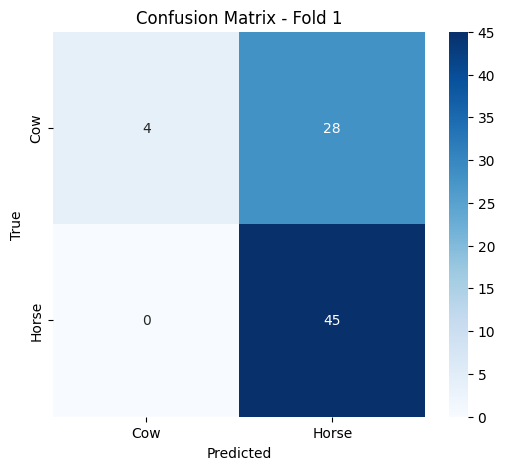

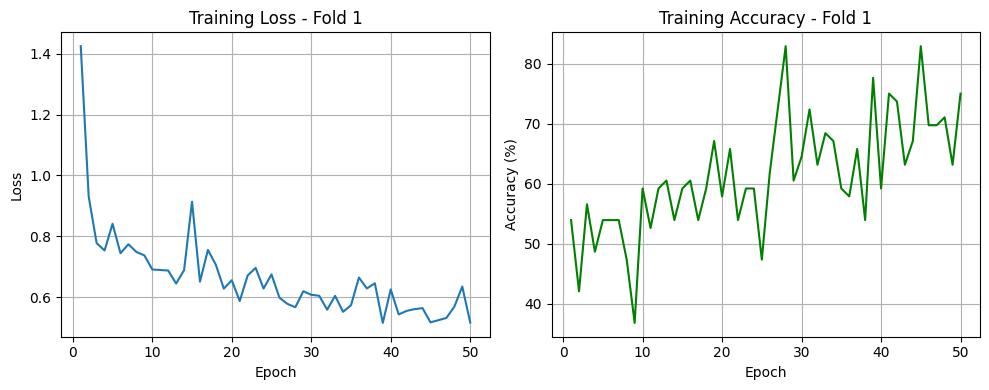


========== Fold 2 ==========
Train distribution: {'Cow': 35, 'Horse': 41}
Test distribution: {'Cow': 42, 'Horse': 35}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.4154, Train Accuracy: 52.63%
Epoch 2/50, Loss: 1.4350, Train Accuracy: 47.37%
Epoch 3/50, Loss: 1.5134, Train Accuracy: 59.21%
Epoch 4/50, Loss: 1.2625, Train Accuracy: 59.21%
Epoch 5/50, Loss: 1.1828, Train Accuracy: 48.68%
Epoch 6/50, Loss: 1.0735, Train Accuracy: 51.32%
Epoch 7/50, Loss: 0.9645, Train Accuracy: 59.21%
Epoch 8/50, Loss: 0.7941, Train Accuracy: 56.58%
Epoch 9/50, Loss: 0.9238, Train Accuracy: 43.42%
Epoch 10/50, Loss: 0.6486, Train Accuracy: 60.53%
Epoch 11/50, Loss: 0.7225, Train Accuracy: 63.16%
Epoch 12/50, Loss: 0.6561, Train Accuracy: 59.21%
Epoch 13/50, Loss: 0.7439, Train Accuracy: 53.95%
Epoch 14/50, Loss: 0.7077, Train Accuracy: 50.00%
Epoch 15/50, Loss: 0.6426, Train Accuracy: 65.79%
Epoch 16/50, Loss: 0.7222, Train Accuracy: 61.84%
Epoch 17/50, Loss: 0.6716, Train Accuracy: 59.21%
Epoch 18/50, Loss: 0.6563, Train Accuracy: 63.16%
Epoch 19/50, Loss: 0.6579, Train Accuracy: 61.84%
Epoch 20/50, Loss: 0.6739, Train Accuracy: 65.79%
Epoch 21/

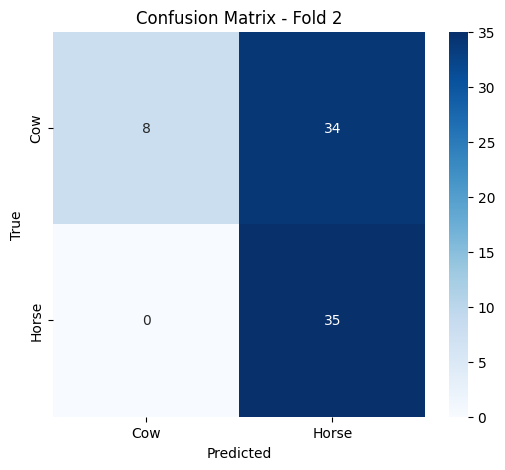

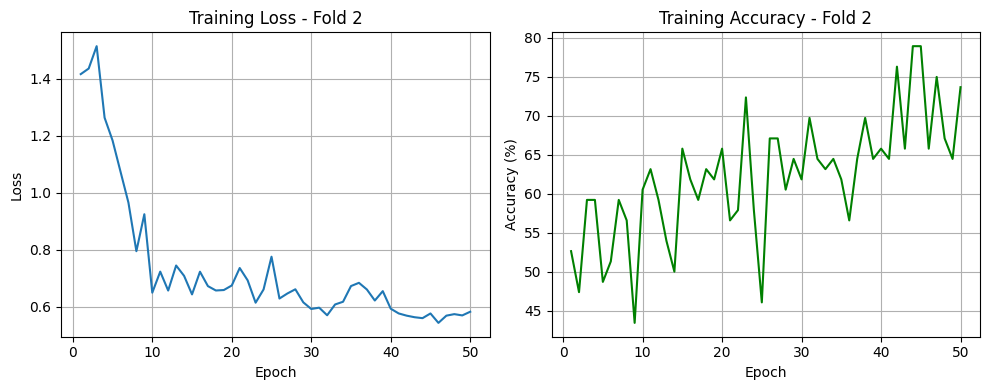


========== Fold 3 ==========
Train distribution: {'Cow': 37, 'Horse': 39}
Test distribution: {'Cow': 36, 'Horse': 41}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 2.1268, Train Accuracy: 48.68%
Epoch 2/50, Loss: 1.6891, Train Accuracy: 48.68%
Epoch 3/50, Loss: 0.8573, Train Accuracy: 61.84%
Epoch 4/50, Loss: 1.3460, Train Accuracy: 51.32%
Epoch 5/50, Loss: 1.1348, Train Accuracy: 48.68%
Epoch 6/50, Loss: 1.1449, Train Accuracy: 47.37%
Epoch 7/50, Loss: 1.0835, Train Accuracy: 55.26%
Epoch 8/50, Loss: 0.9348, Train Accuracy: 46.05%
Epoch 9/50, Loss: 1.1238, Train Accuracy: 51.32%
Epoch 10/50, Loss: 0.7701, Train Accuracy: 55.26%
Epoch 11/50, Loss: 0.6955, Train Accuracy: 63.16%
Epoch 12/50, Loss: 0.7527, Train Accuracy: 48.68%
Epoch 13/50, Loss: 0.5950, Train Accuracy: 72.37%
Epoch 14/50, Loss: 0.7235, Train Accuracy: 52.63%
Epoch 15/50, Loss: 0.6836, Train Accuracy: 51.32%
Epoch 16/50, Loss: 0.6283, Train Accuracy: 60.53%
Epoch 17/50, Loss: 0.6501, Train Accuracy: 65.79%
Epoch 18/50, Loss: 0.6204, Train Accuracy: 59.21%
Epoch 19/50, Loss: 0.5941, Train Accuracy: 68.42%
Epoch 20/50, Loss: 0.6240, Train Accuracy: 63.16%
Epoch 21/

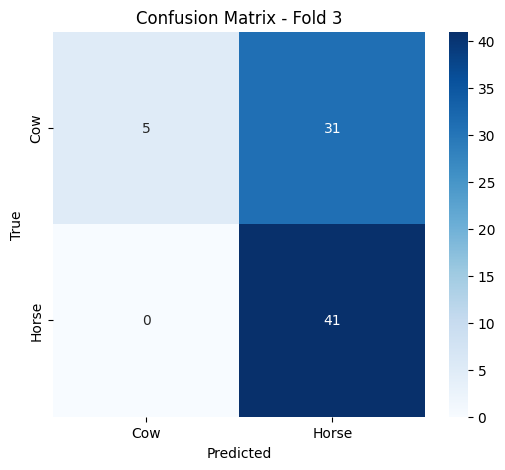

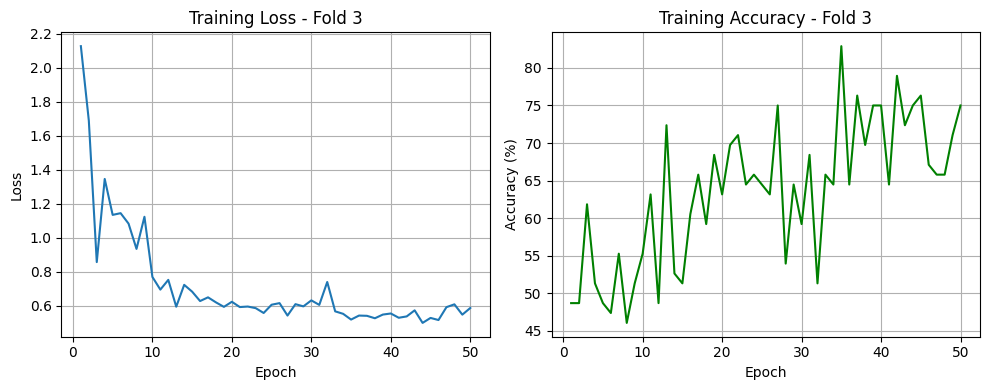


========== Fold 4 ==========
Train distribution: {'Cow': 34, 'Horse': 42}
Test distribution: {'Cow': 45, 'Horse': 32}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.5954, Train Accuracy: 57.89%
Epoch 2/50, Loss: 0.9721, Train Accuracy: 52.63%
Epoch 3/50, Loss: 0.9133, Train Accuracy: 48.68%
Epoch 4/50, Loss: 0.8598, Train Accuracy: 56.58%
Epoch 5/50, Loss: 0.8558, Train Accuracy: 50.00%
Epoch 6/50, Loss: 0.7222, Train Accuracy: 56.58%
Epoch 7/50, Loss: 0.8558, Train Accuracy: 55.26%
Epoch 8/50, Loss: 1.2332, Train Accuracy: 44.74%
Epoch 9/50, Loss: 0.8458, Train Accuracy: 44.74%
Epoch 10/50, Loss: 1.0192, Train Accuracy: 57.89%
Epoch 11/50, Loss: 0.8022, Train Accuracy: 44.74%
Epoch 12/50, Loss: 0.6670, Train Accuracy: 57.89%
Epoch 13/50, Loss: 0.7635, Train Accuracy: 61.84%
Epoch 14/50, Loss: 0.8773, Train Accuracy: 50.00%
Epoch 15/50, Loss: 0.7253, Train Accuracy: 56.58%
Epoch 16/50, Loss: 0.8285, Train Accuracy: 53.95%
Epoch 17/50, Loss: 0.7497, Train Accuracy: 52.63%
Epoch 18/50, Loss: 0.7270, Train Accuracy: 64.47%
Epoch 19/50, Loss: 0.6997, Train Accuracy: 65.79%
Epoch 20/50, Loss: 0.6149, Train Accuracy: 67.11%
Epoch 21/

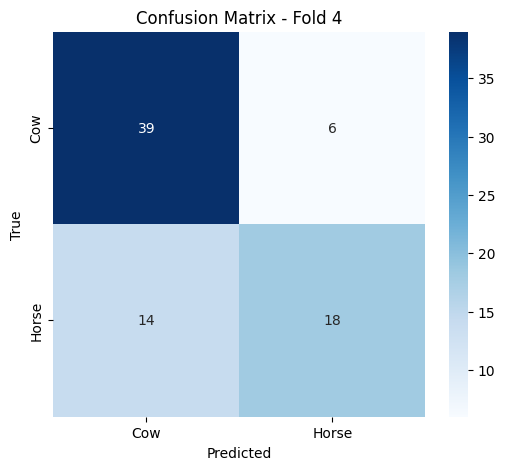

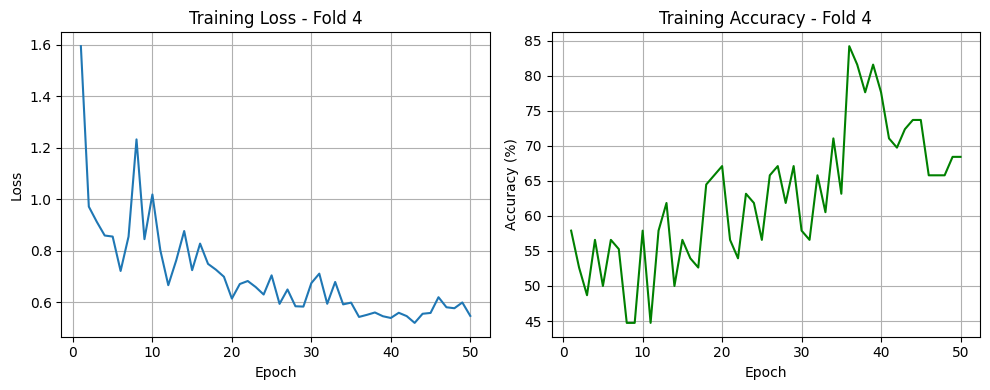


========== Cross-Validation Summary ==========
Fold 1 Accuracy: 63.64%
Fold 2 Accuracy: 55.84%
Fold 3 Accuracy: 59.74%
Fold 4 Accuracy: 74.03%
Average Accuracy: 63.31%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load Train and Test datasets
train_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Test", transform=transform)

# 3. Combine datasets
combined_dataset = ConcatDataset([train_dataset, test_dataset])
class_names = train_dataset.classes

# 4. K-Fold CV setup
k_folds = 4
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
batch_size = 32

# 5. Start K-Fold loop
for fold, (all_idx, _) in enumerate(kf.split(combined_dataset)):
    print(f"\n========== Fold {fold+1} ==========")

    # 60% training, 40% testing split within fold
    np.random.shuffle(all_idx)
    total_len = len(all_idx)
    train_len = int(0.5 * total_len)
    train_idx = all_idx[:train_len]
    test_idx = all_idx[train_len:]

    train_subset = Subset(combined_dataset, train_idx)
    test_subset = Subset(combined_dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Class distribution function
    def get_distribution(indices):
        label_list = [combined_dataset[i][1] for i in indices]
        values, counts = np.unique(label_list, return_counts=True)
        return dict(zip([class_names[i] for i in values], counts))

    print("Train distribution:", get_distribution(train_idx))
    print("Test distribution:", get_distribution(test_idx))

    # Load and modify ResNet50
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    # Freeze all layers except final FC
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.002)

    train_losses = []
    train_accuracies = []

    # Training
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / total
        train_acc = 100 * correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Testing
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot Loss and Accuracy Curve for this fold
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - Fold {fold+1}")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Training Accuracy - Fold {fold+1}")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Summary of all folds
print("\n========== Cross-Validation Summary ==========")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1} Accuracy: {acc:.2f}%")
print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}%")



========== Fold 1 ==========
Train distribution: {'Cow': 39, 'Horse': 37}
Test distribution: {'Cow': 38, 'Horse': 39}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 0.6272, Train Accuracy: 71.05%
Epoch 2/50, Loss: 0.4310, Train Accuracy: 69.74%
Epoch 3/50, Loss: 0.3547, Train Accuracy: 85.53%
Epoch 4/50, Loss: 0.2525, Train Accuracy: 89.47%
Epoch 5/50, Loss: 0.1695, Train Accuracy: 96.05%
Epoch 6/50, Loss: 0.1617, Train Accuracy: 98.68%
Epoch 7/50, Loss: 0.1264, Train Accuracy: 98.68%
Epoch 8/50, Loss: 0.1082, Train Accuracy: 97.37%
Epoch 9/50, Loss: 0.0653, Train Accuracy: 100.00%
Epoch 10/50, Loss: 0.0887, Train Accuracy: 100.00%
Epoch 11/50, Loss: 0.0772, Train Accuracy: 100.00%
Epoch 12/50, Loss: 0.1198, Train Accuracy: 94.74%
Epoch 13/50, Loss: 0.0588, Train Accuracy: 98.68%
Epoch 14/50, Loss: 0.0641, Train Accuracy: 100.00%
Epoch 15/50, Loss: 0.0640, Train Accuracy: 100.00%
Epoch 16/50, Loss: 0.0456, Train Accuracy: 100.00%
Epoch 17/50, Loss: 0.0417, Train Accuracy: 100.00%
Epoch 18/50, Loss: 0.0387, Train Accuracy: 100.00%
Epoch 19/50, Loss: 0.0413, Train Accuracy: 100.00%
Epoch 20/50, Loss: 0.0413, Train Accuracy: 100.00%

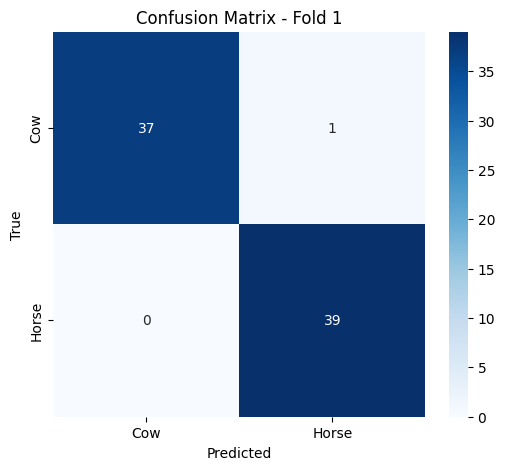

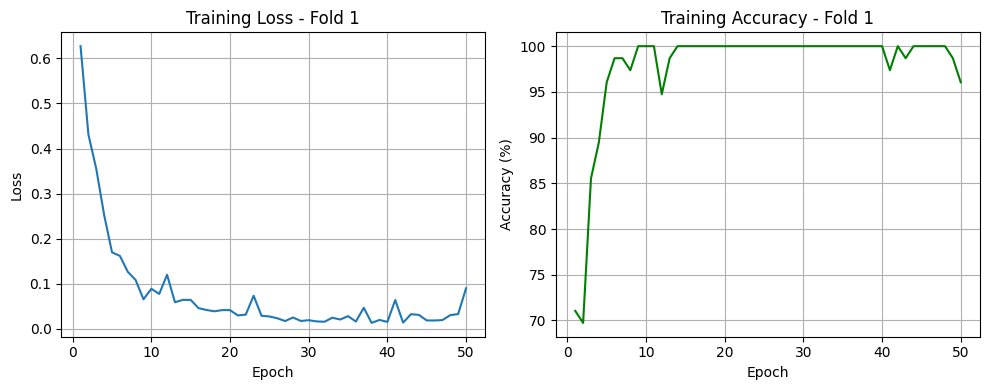


========== Fold 2 ==========
Train distribution: {'Cow': 38, 'Horse': 38}
Test distribution: {'Cow': 39, 'Horse': 38}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 0.7322, Train Accuracy: 55.26%
Epoch 2/50, Loss: 0.5029, Train Accuracy: 64.47%
Epoch 3/50, Loss: 0.5273, Train Accuracy: 59.21%
Epoch 4/50, Loss: 0.1988, Train Accuracy: 98.68%
Epoch 5/50, Loss: 0.3274, Train Accuracy: 85.53%
Epoch 6/50, Loss: 0.1316, Train Accuracy: 98.68%
Epoch 7/50, Loss: 0.2169, Train Accuracy: 94.74%
Epoch 8/50, Loss: 0.1354, Train Accuracy: 97.37%
Epoch 9/50, Loss: 0.1566, Train Accuracy: 97.37%
Epoch 10/50, Loss: 0.1039, Train Accuracy: 97.37%
Epoch 11/50, Loss: 0.0792, Train Accuracy: 100.00%
Epoch 12/50, Loss: 0.1244, Train Accuracy: 100.00%
Epoch 13/50, Loss: 0.0527, Train Accuracy: 100.00%
Epoch 14/50, Loss: 0.0468, Train Accuracy: 100.00%
Epoch 15/50, Loss: 0.0996, Train Accuracy: 98.68%
Epoch 16/50, Loss: 0.0400, Train Accuracy: 100.00%
Epoch 17/50, Loss: 0.0650, Train Accuracy: 98.68%
Epoch 18/50, Loss: 0.0647, Train Accuracy: 98.68%
Epoch 19/50, Loss: 0.0454, Train Accuracy: 100.00%
Epoch 20/50, Loss: 0.0450, Train Accuracy: 98.68%
Epo

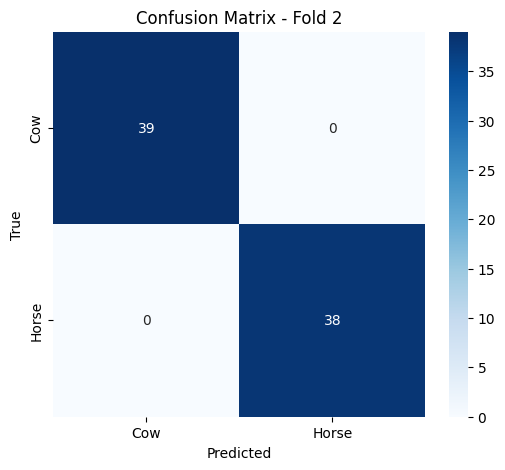

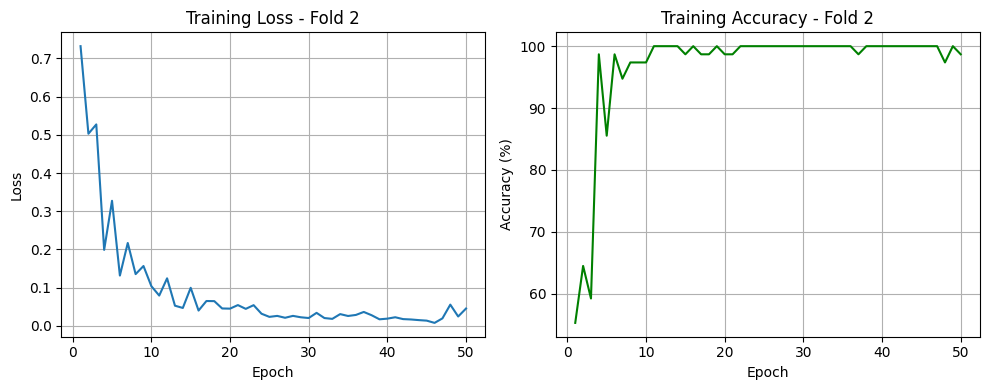


========== Fold 3 ==========
Train distribution: {'Cow': 37, 'Horse': 39}
Test distribution: {'Cow': 36, 'Horse': 41}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.2326, Train Accuracy: 51.32%
Epoch 2/50, Loss: 0.8218, Train Accuracy: 48.68%
Epoch 3/50, Loss: 0.4743, Train Accuracy: 77.63%
Epoch 4/50, Loss: 0.4874, Train Accuracy: 64.47%
Epoch 5/50, Loss: 0.3252, Train Accuracy: 92.11%
Epoch 6/50, Loss: 0.3063, Train Accuracy: 89.47%
Epoch 7/50, Loss: 0.1943, Train Accuracy: 100.00%
Epoch 8/50, Loss: 0.1916, Train Accuracy: 98.68%
Epoch 9/50, Loss: 0.1463, Train Accuracy: 98.68%
Epoch 10/50, Loss: 0.1612, Train Accuracy: 98.68%
Epoch 11/50, Loss: 0.1397, Train Accuracy: 98.68%
Epoch 12/50, Loss: 0.1011, Train Accuracy: 98.68%
Epoch 13/50, Loss: 0.1364, Train Accuracy: 98.68%
Epoch 14/50, Loss: 0.0765, Train Accuracy: 100.00%
Epoch 15/50, Loss: 0.0749, Train Accuracy: 100.00%
Epoch 16/50, Loss: 0.0974, Train Accuracy: 98.68%
Epoch 17/50, Loss: 0.0547, Train Accuracy: 100.00%
Epoch 18/50, Loss: 0.0722, Train Accuracy: 100.00%
Epoch 19/50, Loss: 0.0597, Train Accuracy: 100.00%
Epoch 20/50, Loss: 0.0488, Train Accuracy: 100.00%
Ep

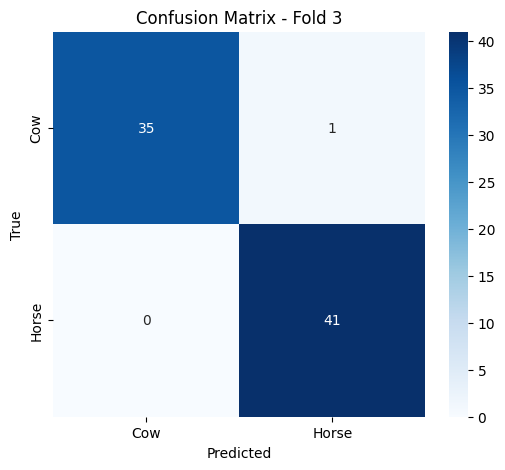

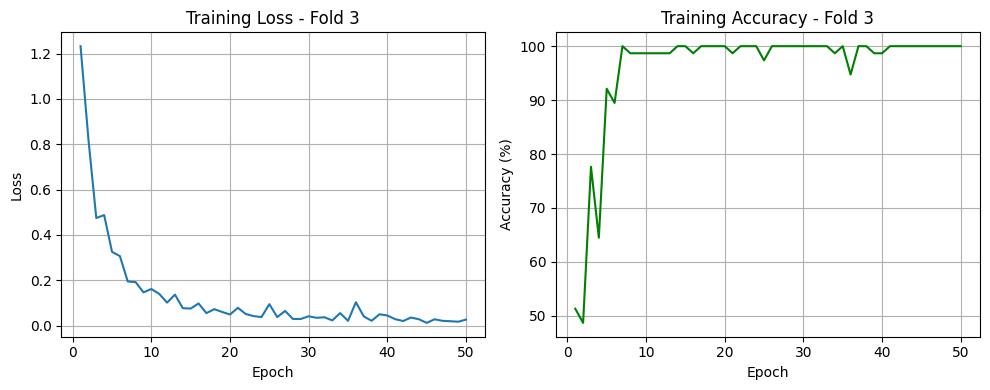


========== Fold 4 ==========
Train distribution: {'Cow': 41, 'Horse': 35}
Test distribution: {'Cow': 38, 'Horse': 39}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 0.9358, Train Accuracy: 48.68%
Epoch 2/50, Loss: 1.0995, Train Accuracy: 53.95%
Epoch 3/50, Loss: 0.6399, Train Accuracy: 68.42%
Epoch 4/50, Loss: 0.6093, Train Accuracy: 57.89%
Epoch 5/50, Loss: 0.2586, Train Accuracy: 98.68%
Epoch 6/50, Loss: 0.3461, Train Accuracy: 84.21%
Epoch 7/50, Loss: 0.1941, Train Accuracy: 98.68%
Epoch 8/50, Loss: 0.2124, Train Accuracy: 96.05%
Epoch 9/50, Loss: 0.1936, Train Accuracy: 97.37%
Epoch 10/50, Loss: 0.1444, Train Accuracy: 100.00%
Epoch 11/50, Loss: 0.1167, Train Accuracy: 100.00%
Epoch 12/50, Loss: 0.0896, Train Accuracy: 100.00%
Epoch 13/50, Loss: 0.0691, Train Accuracy: 100.00%
Epoch 14/50, Loss: 0.0775, Train Accuracy: 100.00%
Epoch 15/50, Loss: 0.0572, Train Accuracy: 100.00%
Epoch 16/50, Loss: 0.0547, Train Accuracy: 100.00%
Epoch 17/50, Loss: 0.0511, Train Accuracy: 100.00%
Epoch 18/50, Loss: 0.0410, Train Accuracy: 100.00%
Epoch 19/50, Loss: 0.0443, Train Accuracy: 100.00%
Epoch 20/50, Loss: 0.0440, Train Accuracy: 100.00

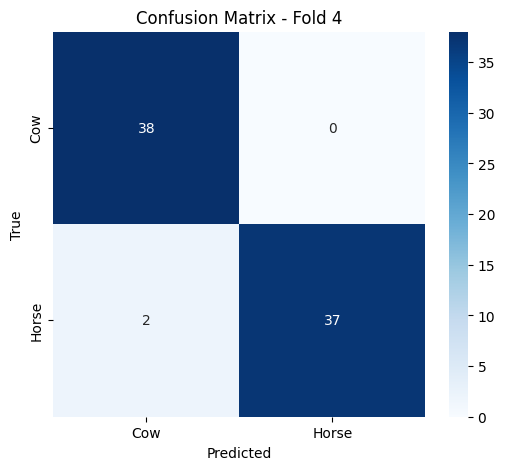

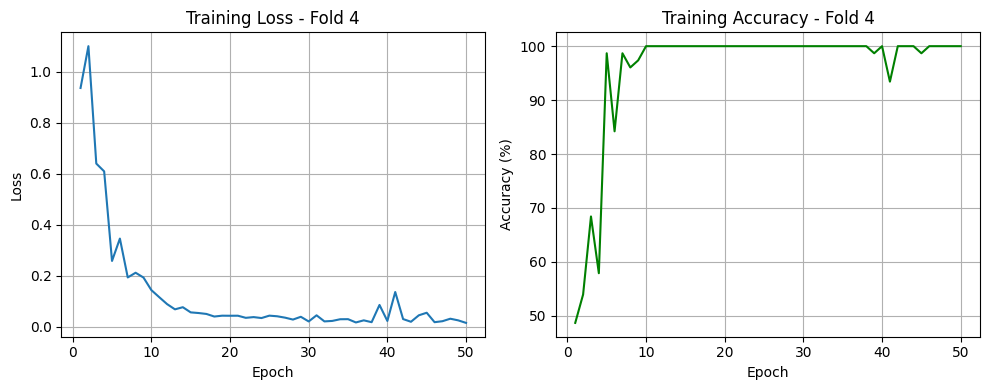


========== Cross-Validation Summary ==========
Fold 1 Accuracy: 98.70%
Fold 2 Accuracy: 100.00%
Fold 3 Accuracy: 98.70%
Fold 4 Accuracy: 97.40%
Average Accuracy: 98.70%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load Train and Test datasets
train_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Test", transform=transform)

# 3. Combine datasets
combined_dataset = ConcatDataset([train_dataset, test_dataset])
class_names = train_dataset.classes

# 4. K-Fold CV setup
k_folds = 4
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
batch_size = 32

# 5. Start K-Fold loop
for fold, (all_idx, _) in enumerate(kf.split(combined_dataset)):
    print(f"\n========== Fold {fold+1} ==========")

    # 60% training, 40% testing split within fold
    np.random.shuffle(all_idx)
    total_len = len(all_idx)
    train_len = int(0.5 * total_len)
    train_idx = all_idx[:train_len]
    test_idx = all_idx[train_len:]

    train_subset = Subset(combined_dataset, train_idx)
    test_subset = Subset(combined_dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Class distribution function
    def get_distribution(indices):
        label_list = [combined_dataset[i][1] for i in indices]
        values, counts = np.unique(label_list, return_counts=True)
        return dict(zip([class_names[i] for i in values], counts))

    print("Train distribution:", get_distribution(train_idx))
    print("Test distribution:", get_distribution(test_idx))

    # Load and modify ResNet50
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    # Freeze all layers except final FC
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.002)

    train_losses = []
    train_accuracies = []

    # Training
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / total
        train_acc = 100 * correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Testing
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot Loss and Accuracy Curve for this fold
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - Fold {fold+1}")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Training Accuracy - Fold {fold+1}")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Summary of all folds
print("\n========== Cross-Validation Summary ==========")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1} Accuracy: {acc:.2f}%")
print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/100], Loss: 0.6886, Accuracy: 55.74%
Epoch [2/100], Loss: 0.6756, Accuracy: 62.30%
Epoch [3/100], Loss: 0.6764, Accuracy: 60.66%
Epoch [4/100], Loss: 0.6547, Accuracy: 63.11%
Epoch [5/100], Loss: 0.6592, Accuracy: 63.11%
Epoch [6/100], Loss: 0.6513, Accuracy: 59.84%
Epoch [7/100], Loss: 0.6155, Accuracy: 80.33%
Epoch [8/100], Loss: 0.6333, Accuracy: 72.95%
Epoch [9/100], Loss: 0.6063, Accuracy: 77.05%
Epoch [10/100], Loss: 0.6263, Accuracy: 66.39%
Epoch [11/100], Loss: 0.6250, Accuracy: 69.67%
Epoch [12/100], Loss: 0.6075, Accuracy: 68.85%
Epoch [13/100], Loss: 0.5938, Accuracy: 74.59%
Epoch [14/100], Loss: 0.6039, Accuracy: 73.77%
Epoch [15/100], Loss: 0.5803, Accuracy: 77.05%
Epoch [16/100], Loss: 0.5895, Accuracy: 71.31%
Epoch [17/100], Loss: 0.5617, Accuracy: 79.51%
Epoch [18/100], Loss: 0.5681, Accuracy: 77.87%
Epoch [19/100], Loss: 0.5563, Accuracy: 81.97%
Epoch [20/100], Loss: 0.5617, Accuracy: 77.05%
Epoch [21/100], Loss: 0.5490, Accuracy: 78.69%
Epoch [22/100], Loss: 

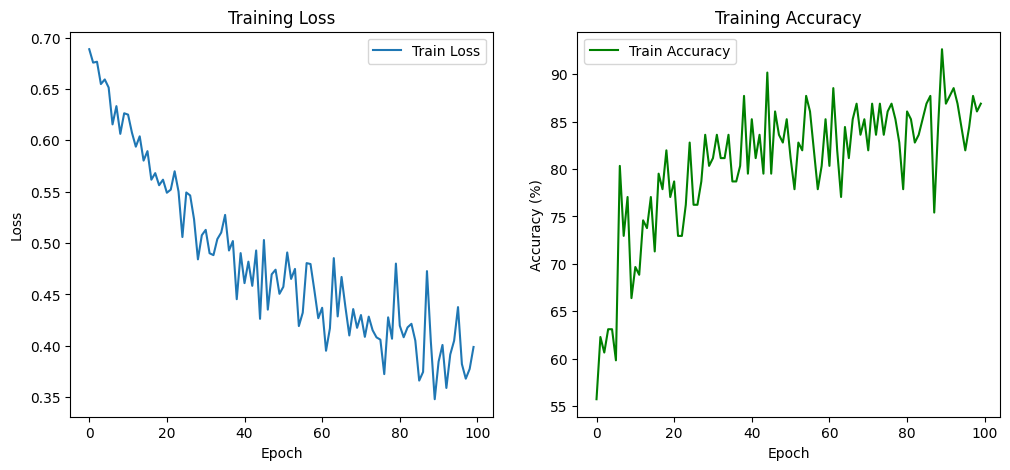

Test Accuracy: 64.63%


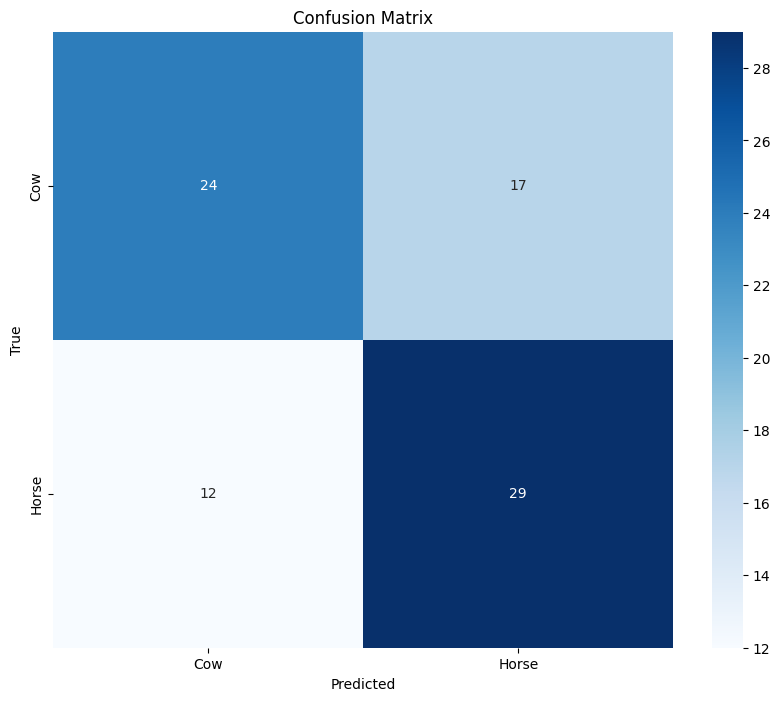

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to fit VGG16 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# 2. Load datasets (change root as needed)
train_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Use Pretrained VGG16 model from torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained VGG16 model
model = models.vgg16(pretrained=False)

# Modify the final fully connected layer for your number of classes (2 classes in your case)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Move model to device
model = model.to(device)

# Optionally, freeze the layers if you want to fine-tune only the final layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer (this is usually the layer we fine-tune)
for param in model.classifier[6].parameters():
    param.requires_grad = True

# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.002)

# 5. Training loop
num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# 6. Plot train accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()
plt.show()

# 7. Evaluation on test set + confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
correct = np.sum(np.array(y_true) == np.array(y_pred))
test_acc = 100 * correct / len(y_true)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 193MB/s] 


Epoch [1/50], Loss: 0.4664, Accuracy: 72.95%
Epoch [2/50], Loss: 0.1405, Accuracy: 94.26%
Epoch [3/50], Loss: 0.0712, Accuracy: 97.54%
Epoch [4/50], Loss: 0.0410, Accuracy: 98.36%
Epoch [5/50], Loss: 0.0206, Accuracy: 100.00%
Epoch [6/50], Loss: 0.0072, Accuracy: 100.00%
Epoch [7/50], Loss: 0.0063, Accuracy: 100.00%
Epoch [8/50], Loss: 0.0077, Accuracy: 100.00%
Epoch [9/50], Loss: 0.0054, Accuracy: 100.00%
Epoch [10/50], Loss: 0.0052, Accuracy: 100.00%
Epoch [11/50], Loss: 0.0073, Accuracy: 100.00%
Epoch [12/50], Loss: 0.0045, Accuracy: 100.00%
Epoch [13/50], Loss: 0.0026, Accuracy: 100.00%
Epoch [14/50], Loss: 0.0054, Accuracy: 100.00%
Epoch [15/50], Loss: 0.0028, Accuracy: 100.00%
Epoch [16/50], Loss: 0.0036, Accuracy: 100.00%
Epoch [17/50], Loss: 0.0024, Accuracy: 100.00%
Epoch [18/50], Loss: 0.0030, Accuracy: 100.00%
Epoch [19/50], Loss: 0.0030, Accuracy: 100.00%
Epoch [20/50], Loss: 0.0028, Accuracy: 100.00%
Epoch [21/50], Loss: 0.0009, Accuracy: 100.00%
Epoch [22/50], Loss: 0.001

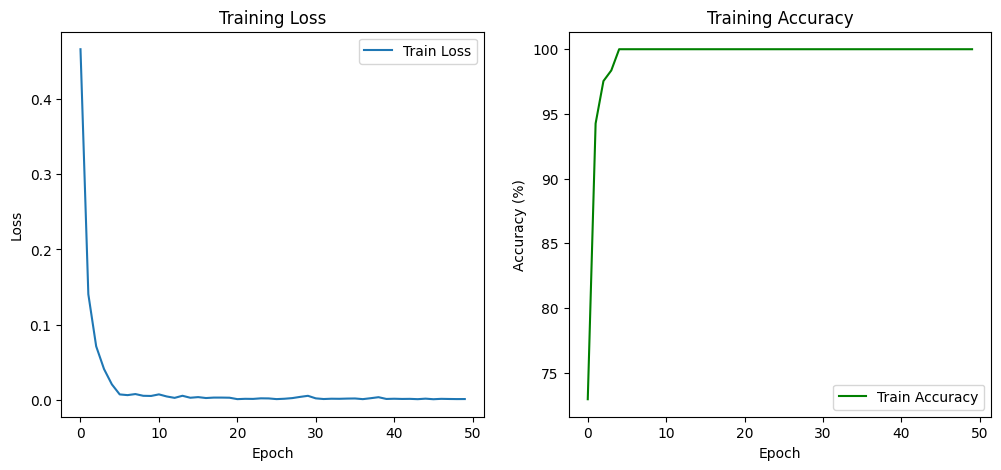

Test Accuracy: 70.73%


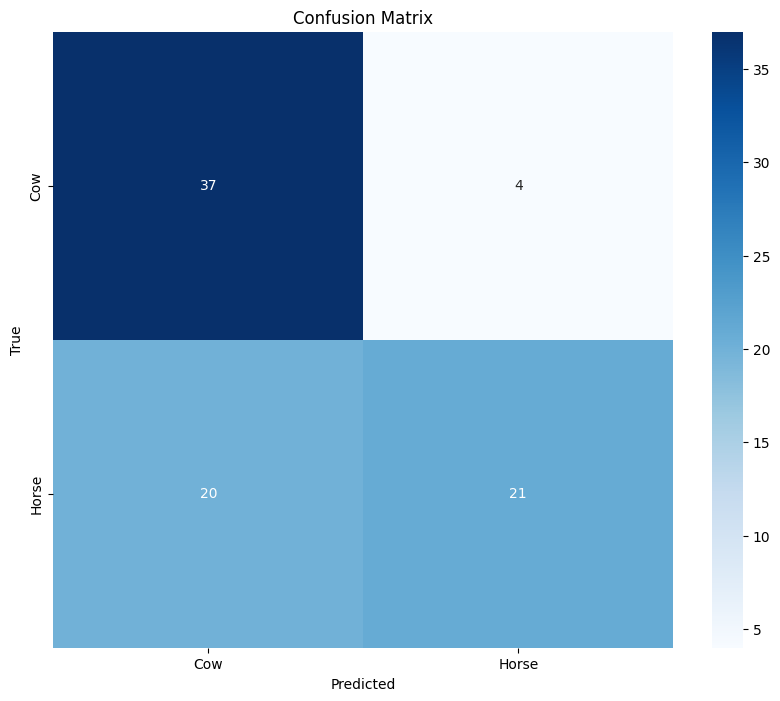

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to fit VGG16 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# 2. Load datasets (change root as needed)
train_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Use Pretrained VGG16 model from torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the final fully connected layer for your number of classes (2 classes in your case)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Move model to device
model = model.to(device)

# Optionally, freeze the layers if you want to fine-tune only the final layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer (this is usually the layer we fine-tune)
for param in model.classifier[6].parameters():
    param.requires_grad = True

# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.002)

# 5. Training loop
num_epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# 6. Plot train accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()
plt.show()

# 7. Evaluation on test set + confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
correct = np.sum(np.array(y_true) == np.array(y_pred))
test_acc = 100 * correct / len(y_true)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 195MB/s]  


Epoch [1/50], Loss: 0.7149, Accuracy: 59.02%
Epoch [2/50], Loss: 0.3347, Accuracy: 83.61%
Epoch [3/50], Loss: 0.1296, Accuracy: 95.08%
Epoch [4/50], Loss: 0.0972, Accuracy: 95.90%
Epoch [5/50], Loss: 0.0366, Accuracy: 100.00%
Epoch [6/50], Loss: 0.0302, Accuracy: 100.00%
Epoch [7/50], Loss: 0.0241, Accuracy: 100.00%
Epoch [8/50], Loss: 0.0180, Accuracy: 100.00%
Epoch [9/50], Loss: 0.0160, Accuracy: 100.00%
Epoch [10/50], Loss: 0.0106, Accuracy: 100.00%
Epoch [11/50], Loss: 0.0122, Accuracy: 100.00%
Epoch [12/50], Loss: 0.0070, Accuracy: 100.00%
Epoch [13/50], Loss: 0.0096, Accuracy: 100.00%
Epoch [14/50], Loss: 0.0094, Accuracy: 100.00%
Epoch [15/50], Loss: 0.0124, Accuracy: 99.18%
Epoch [16/50], Loss: 0.0126, Accuracy: 100.00%
Epoch [17/50], Loss: 0.0041, Accuracy: 100.00%
Epoch [18/50], Loss: 0.0069, Accuracy: 100.00%
Epoch [19/50], Loss: 0.0077, Accuracy: 100.00%
Epoch [20/50], Loss: 0.0040, Accuracy: 100.00%
Epoch [21/50], Loss: 0.0061, Accuracy: 100.00%
Epoch [22/50], Loss: 0.0066

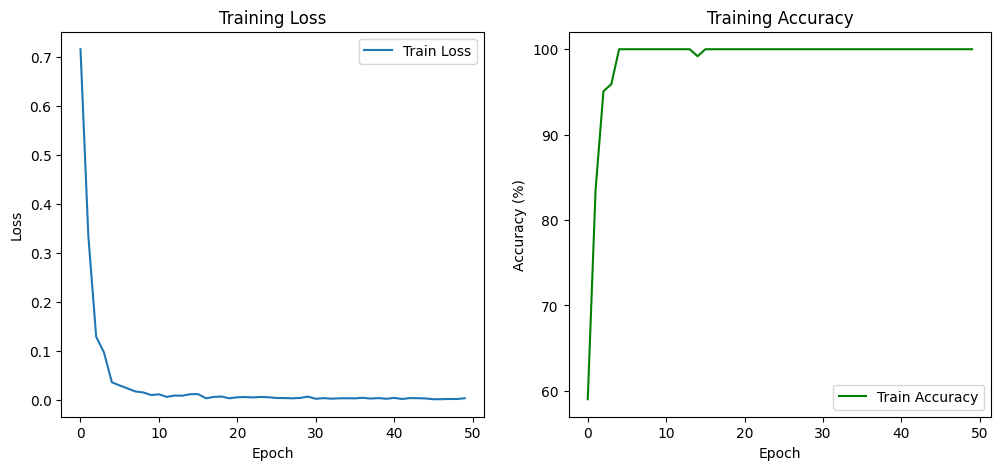

Test Accuracy: 62.20%


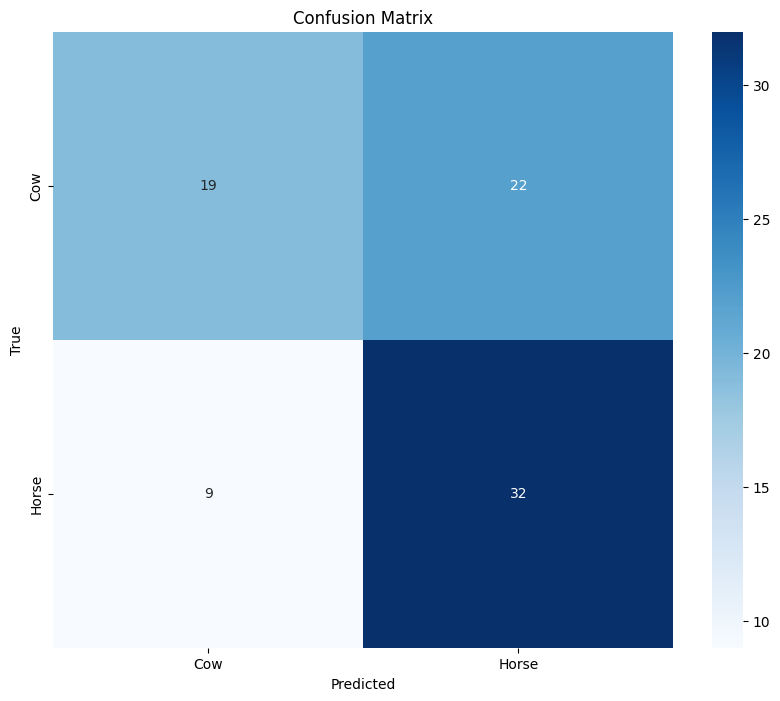

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to fit VGG16 input
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# 2. Load datasets (change root as needed)
train_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/vision-project-aug/Newdata_Aug/Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Use Pretrained VGG16 model from torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained VGG16 model
model = models.vgg19(pretrained=True)

# Modify the final fully connected layer for your number of classes (2 classes in your case)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Move model to device
model = model.to(device)

# Optionally, freeze the layers if you want to fine-tune only the final layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer (this is usually the layer we fine-tune)
for param in model.classifier[6].parameters():
    param.requires_grad = True

# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.002)

# 5. Training loop
num_epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# 6. Plot train accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()
plt.show()

# 7. Evaluation on test set + confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
correct = np.sum(np.array(y_true) == np.array(y_pred))
test_acc = 100 * correct / len(y_true)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
